# Grade: /100 pts

# Assignment 05: Model Selection & Cross Validation

### Dear Applicant...You've Been Invited To  Interview To Be A Data Scientist!

You've been invited to interview for a Junior Data Scientist job for a professional football (er, Soccer) club.  The owner of the team is very interested in seeing how the use of data can help improve the team's peformance, and perhaps win them the next national championship!

The draft is coming up soon (thats when you get to pick new players for your team). To test your skills, the owner has asked you to create a model to help score potential draftees.  The model should look at attributes about the player and predict what their "rating" will be once they start playing professionally.

The football club's data team has provided you with data for 17,993 footballers from the league.  Your job: build a model or models, perform model selection, and make predictions on players you have not yet seen.

### The Dataset

The data is stored in a csv file called `footballer_data.csv`.  The data contain 52 columns, including some information about the player, their skills, and their overall measure as an effective footballer.

Most features relate to the player's abilities in football related skills, such as passing, shooting, dribbling, etc.  Some features are rated on a 1-5 scale (5 being the best), others are rated on 0-100 (100 being the best), and others still are categorical (e.g. work rate is coded as low, medium, or high).

The target variable (or $y$ variable, if you will) is `overall`.  This is an overall measure of the footballer's skill and is rated from 0 to 100.  The most amazingly skilled footballer would be rated 100, where as I would struggle to score more than a 20. The model(s) you build should use the other features to predict `overall`.


### Follow These Steps before submitting
Once you are finished, ensure to complete the following steps.

1.  Restart your kernel by clicking 'Kernel' > 'Restart & Run All'.

2.  Fix any errors which result from this.

3.  Repeat steps 1. and 2. until your notebook runs without errors.

4.  Submit your completed notebook to OWL by the deadline.


### Preliminaries
---

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.linear_model import LinearRegression
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.metrics import make_scorer, mean_squared_error
from sklearn.base import BaseEstimator, TransformerMixin

pd.set_option('display.max_columns', 500)

%matplotlib inline


### Question 1: /10pts

The hiring manager is going to walk you through a data analysis.  Your job is to implement what they ask to showcase yous skills as a data scientist.

Read in the data and take a look at the dataframe.  There should be 52 columns. The outcome of interest is called `overall` which gives an overall measure of player performance. Not all of the other columns are particularly useful for modelling though (for instance, `ID` is just a unique identifier for the player.  This is essentially an arbitrary number and has no bearing on the player's rating).

The hiring manager tells you to remove the following columns:

* ID
* club
* club_logo
* birth_date
* flag
* nationality
* photo
* potential

The hiring manager would also like the following columns converted into dummy variables:

* work_rate_att
* work_rate_def
* preferred_foot

Clean the data according to the hiring manager's instructions.

In [2]:
df = pd.read_csv('footballer_data.csv')
# Remove the following columns
model_data = df.drop(['ID','club','club_logo','flag', 'nationality','photo','potential', 'birth_date'], axis = 'columns')
# Create Dummy Variables
model_data['work_rate_att'] = pd.Categorical(model_data.work_rate_att, categories=['Low','Medium','High'])
model_data['work_rate_def'] = pd.Categorical(model_data.work_rate_def, categories=['Low','Medium','High'])
model_data['preferred_foot'] = pd.Categorical(model_data.preferred_foot, categories=['Left','Right'])
# Drop first category
model_data = pd.get_dummies(model_data, drop_first=True)
# Display the cleaned data
model_data.head()

,age,height_cm,weight_kg,overall,pac,sho,pas,dri,def,phy,international_reputation,skill_moves,weak_foot,crossing,finishing,heading_accuracy,short_passing,volleys,dribbling,curve,free_kick_accuracy,long_passing,ball_control,acceleration,sprint_speed,agility,reactions,balance,shot_power,jumping,stamina,strength,long_shots,aggression,interceptions,positioning,vision,penalties,composure,marking,standing_tackle,work_rate_att_Medium,work_rate_att_High,work_rate_def_Medium,work_rate_def_High,preferred_foot_Right
0,32,185.0,80.0,94,90,93,82,90,33,80,5,5,4,85,94,88,83,88,91,81,76,77,93,89,91,89,96,63,94,95,92,80,92,63,29,95,85,85,95,22,31,0,1,0,0,1
1,30,170.0,72.0,93,89,90,86,96,26,61,5,4,4,77,95,71,88,85,97,89,90,87,95,92,87,90,95,95,85,68,73,59,88,48,22,93,90,78,96,13,28,1,0,1,0,0
2,25,175.0,68.0,92,92,84,79,95,30,60,5,5,5,75,89,62,81,83,96,81,84,75,95,94,90,96,88,82,80,61,78,53,77,56,36,90,80,81,92,21,24,0,1,1,0,1
3,30,182.0,86.0,92,82,90,79,87,42,81,5,4,4,77,94,77,83,88,86,86,84,64,91,88,77,86,93,60,87,69,89,80,86,78,41,92,84,85,83,30,45,0,1,1,0,1
4,31,193.0,92.0,92,91,90,95,89,60,91,5,1,4,15,13,25,55,11,30,14,11,59,48,58,61,52,85,35,25,78,44,83,16,29,30,12,70,47,70,10,10,1,0,1,0,1


### Question 2: /10 pts

The data should all be numerical now. To evalute different models, the hiring manager asks you to define a function that returns the mean squared error. 

*"Before we begin modelling, it is important to obtain a baseline for the accuracy of our predictive models."* says the hiring manager. *Compute the squared errors resulting if we use the mean of the `overall` variable to make predictions. Then compute the expected loss. This will serve as our baseline performance.*

Plot the distribution of the losses (squared errors) and print their mean and standard deviation.

C:\Users\gerri\anaconda3\lib\site-packages\seaborn\distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='overall', ylabel='Density'>

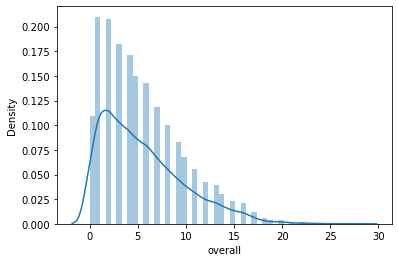

In [3]:
# Define mean absolute error function  
def mae(y, ypred):
    return abs(y - ypred).mean()

# Get mean and std of test loss 
mu = mae(model_data.overall, model_data.overall.median())
loss = abs(model_data.overall - model_data.overall.median())
sigma = loss.std()

# Plot distribution  
sns.distplot(loss)



### Question 2: /15pts

To prepare the data for modelling, the hiring manager asks you use `sklearn.model_selection.train_test_split` to seperate the data into a training set and a test set.

The hiring manager would like you to estimate the performance of the final selected model to within +/- 0.25 units using mean squared error as the loss function of choice.  You remember that you can use the formula for effective test size to accomplish this.

The formula for the effective test size is

$$ n = \left(\frac{1.96 \sigma_l}{d}\right)^2$$

Can you estimate the performance of the model to within their desired precsion? Why or why not?  If you can't, tell the hiring manager why you can't and then tell them what precision splitting the data into 50% train and 50% test will achieve.

Include your answer as if you were writing the hiring manager an email in a markdown cell below...

Hey Hiring Manager,



In [4]:
# Provide your calculation as evidence
d = 0.25
test_size = (2*sigma/d)**2
y = model_data.overall
X = model_data.drop('overall', axis = 'columns')

Xtrain, Xtest, ytrain, ytest = train_test_split(X, y, test_size = int(np.ceil(test_size)), random_state = 0)

print(Xtrain.shape,Xtest.shape)

(16831, 45) (1163, 45)


### Question 4: /5pts
The team at the football clib use sklearn to build a model pipelines for their projects. To learn more about pipelines, do lab section 5.9 (lab part 2) and read up on sklearn pipelines [here](https://scikit-learn.org/stable/modules/generated/sklearn.pipeline.Pipeline.html). 

The hiring manager want you to create a model pipeline to be fit later.  Create an sklearn pipeline which fits a linear regression model.  Don't fit the data yet!  The hiring manager will tell you when to do that...

Note that the sklearn linear regression adds its own intercept so you don't need to create a column of 1s.


In [5]:
model = Pipeline([('linear_regression', LinearRegression())])

### Question 5: /15pts

The hiring manager wants you to perform cross validation on the model you constructed in the last question.  They want to make sure you understand what cross validation is, so they've asked you to **write your own function to do cross validation.  Do not use sklearn's functions to do this for you.  Else, you won't get the job!**.


Your function should take the following arguments:

* `model` -- an instance of an sklearn pipeline (like the one you made in the last question)
* `X` -- a matrix of features
* `y` -- a vector of outcomes (remember we're using the "overall" column from the data)
* `K` -- an integer no smaller than 1 and no larger than 10.  This represents the number of folds to make in the cross validation step.
* `scoring` -- a loss function.  

Your function should return:

* cv_scores -- an array of length `K`.  This houses the cross validation estimates from each fold.

Perform 5 fold cross validation with your function.  Report the estimated average mean square error from your cross validation.

Note: Please make sure you write your own function to perform crossvalidation. While you can use sklearn's `cross_val_score` the main aim of this question is to test that you have a thorough understanding of cross-validation.

In [6]:
def cross_validate(model, X, y, K, scoring_function):
   # Divide data set randomly into K partitions
    xFolds = np.split(XTrain4, 5)
    yFolds = np.split(yTrain,5)
    print(yTrain)
    fold = 0
    errors=[]

    for i in l:
        print('lambda value: ',i,'\n')
        fold = 0
        error = 0
        for f in xFolds:
            trainingSetx = np.delete(xFolds, fold, 0)
            validationSetx = xFolds[fold]
            trainingSetx = np.concatenate(trainingSetx)
            trainingSety = np.delete(yFolds, fold, 0)
            validationSety = yFolds[fold]
            trainingSety = np.concatenate(trainingSety)
            w = np.linalg.inv((trainingSetx.T@trainingSetx) + (i*identity)) @ trainingSetx.T @ trainingSety
            m = xTrain.size
            errt = np.subtract(validationSetx@w,validationSety)
            err = (np.sum(np.square(errt))) / m
            error += err
            fold += 1

        error = error/5
        print('avg error is: ', error)
        errors.append(error)
        # For each crossvalidation fold, fit the model on K-1 partitions and evaluation on the remaning Kth partition 
        return cv_scores
    
# Test your function with K = 5
K = 5
cross_validate(model, X, y , K, loss)

NameError: name 'XTrain4' is not defined

### Question 6: /15pts

That's impressive!  Your model seems to be very accurate, but now the hiring manager wants to try and make it more accurate.  They share with you that scounts see that players hit their prime in their late 20s, and as they age they become worse overall.  Thus, the effect of age seems to increase at first and then start to decrease.  Kind of like a quadratic funciton.

The hiring manager wants you to add a quadratic term for age to the model.  Repeat the steps above (creating a pipeline, validating the model, etc) for a model which includes a quadratic term for age. As in the Lab, include the addition of the quadratic term for Age as a Transform into the pipeline. Report the cross validated performance below.

In [7]:
class AgeNew(BaseEstimator,TransformerMixin):  
    def fit(self,X,y=None):
        return self
    
    def transform(self,X,y=None):
        X = X.assign(age2 = X.age**2)
        return X

model2 = Pipeline([('AgeNew', AgeNew()),('linear_regression', LinearRegression())])
quad_cv_score = cross_val_score(model2, Xtrain, ytrain, cv = 5, scoring=make_scorer(mae))
print(quad_cv_score.mean())

1.887266260520229


### Question 7: /10 pts


Hmmm...You aren't happy that the quadratic age  term has not improved the fit of the model.  You *really* want to impress the hiring manager, and decide to add more features to your model in hopes it will improve performance. 

Add sklearn's `PolynomialFeatures` to your pipeline from question 5 and set `degree=2`. Cross validate the new model and report the performance.

In [8]:
model3 = Pipeline([('poly', PolynomialFeatures(degree=2,include_bias = False)),('linear_regression', LinearRegression())])
quad_cv_score = cross_val_score(model3, Xtrain, ytrain, cv = 5, scoring=make_scorer(mae))
print(quad_cv_score.mean())

0.8861587663421406


### Question 8: /10pts

Great job!  You've managed to decrease the loss by a lot!  The hiring manager is really impressed with your work and things are looking good for your employment status!  

However, the hiring manager is a little too happy with your peformance.  The hiring manager wants to explore third order interactions (that is adding cubic terms to the model).  The hiring manager tells you that their super computers can handle the computation; "*It's no big deal for us*" they boast.
 
This is not a good idea, and you know it!  Talk them out of doing this.  Write them an email in the cell below explaining what could happen if you add too may interactions.

---

Hey Hiring Manager,

I recieved your email about adding cubic terms to the model. I believe that adding cubic terms to the model will likely overfit the data and then the number of predictors will be very close to the number of observations. 
This will result in a low training error, but will likely not generalize very well and I recomendation that we do not add cubic terms.

Sincerly,

Junior Data Scientist




### Question 9:  /10pts

You've successfully talked the hiring manager out of adding cubic terms to the model. Good job!  Now the hiring manager asks for your opinion.  Over the course of the interview, you've fit three models.  It is time to pick a model to deploy!

Based on the cross validation scores, which model would you choose?  
Train your chosen model on all the training data. 
Estimate the performance of your chosen model on the test data you held out, and do the following:

- Compute a point estimate for the generalization error. (A "point estimate" is a single number that we expect to be close to the thing we are trying to estimate.)
- Compute a confidence interval for the generalization error.  
- Plot the distribution of the squared errors.

Is the test error close to the cross validation error of the model you chose? Why do you think this is the case? Answer below as if you were talking to the hiring manager.


Hey Hiring Manager,

...

In [ ]:
model3.fit(Xtrain, ytrain)

ypred = model3.predict(Xtest)

test_errors = np.abs(ytest - ypred)
gError = test_errors.mean()

tCI = gError + 1.96 * np.std(test_errors) / np.sqrt(len(test_errors)) * np.array([-1,1])

sns.distplot(abs(test_errors))

print('The Generalization Error is :', gError)
print('The Confidence Interval is:', tCI)

### Follow These Steps before submitting
Once you are finished, ensure to complete the following steps.

1.  Restart your kernel by clicking 'Kernel' > 'Restart & Run All'.

2.  Fix any errors which result from this.

3.  Repeat steps 1. and 2. until your notebook runs without errors.

4.  Submit your completed notebook to OWL by the deadline.